In [34]:
import sys
sys.path.append('../')
from ressource.utils import read_file_and_create_graph, visualize_paths, Graph
import ressource.utils as utils

In [3]:
import os

# Get the current working directory
current_path = os.getcwd()

# Go up one directory to the parent directory
parent_path = os.path.abspath(os.path.join(current_path, os.pardir))

# Construct the path to the 'data' directory
data_path = os.path.join(parent_path, 'data')

# Get a list of all items (files and folders) in the 'data' directory
all_items = os.listdir(data_path)

# Filter the items to include only folders that start with "Set"
set_folders = [item for item in all_items if os.path.isdir(os.path.join(data_path, item)) and item.startswith('Set')]
data_paths=[]
for folder in set_folders:
    data_paths.append(os.path.join(data_path, folder))


In [4]:
directory_path=data_paths[0]
all_items = os.listdir(directory_path)
txt_files = [os.path.join(directory_path, item) for item in all_items if os.path.isfile(os.path.join(directory_path, item)) and item.endswith('.txt')]

In [5]:
graph_object = read_file_and_create_graph(txt_files[0])

genetic representation
Fitness function
genome
crossover => cross two solution and get a better one 
mutation => change a random bit in genome with a certain probability

In [6]:
def farthest_insertion(points, starting_point, ending_point):
    """Heuristique d'insertion du plus point le plus lointain pour le TSP."""
    n = len(points)

    pts = [point for point in points]
    # Choix arbitraire de deux points comme points de départ
    tour = [starting_point, ending_point]

    pts.pop(pts.index(starting_point)) # suppression de points[0]
    pts.pop(pts.index(ending_point)) # suppression de points[1]


    while len(pts) > 0 :
        # Trouver le point le plus éloigné
        max_dist = -1
        farthest_point = (0, 0)
        pt_tour = (0,0)
        for i in range(len(pts)):
            for point_tour in tour:
                if utils.distance(pts[i], point_tour) > max_dist:
                    max_dist = utils.distance(pts[i], point_tour)
                    farthest_point = pts[i]
                    pt_tour = point_tour

        # Trouver l'arête du tour actuel qui minimise l'ajout de longueur
        min_insertion_cost = float('inf')
        insert_index = 0
        for i in range(len(tour) - 1):
            # Variation de coût d'introduction du point le plus loin entre 2 noeuds
            d = utils.distance(tour[i], farthest_point) + utils.distance(farthest_point, tour[i + 1]) - utils.distance(tour[i],tour[i + 1])

            # Minimisation de la variation
            if d < min_insertion_cost:
                min_insertion_cost = d
                insert_index = i + 1

        # Insérer le point le plus éloigné à l'emplacement identifié
        tour.insert(insert_index, farthest_point)
        pts.pop(pts.index(farthest_point))

    return tour

In [7]:
"""Algorithme de Beasley pour le TOP"""
starting_point=graph_object.getNodes()[0]
ending_point=graph_object.getNodes()[-1]
heuristic_path = farthest_insertion(graph_object.getNodes(),starting_point,ending_point)
convoy = []
paths = []
# On supprime les noeuds de départ et d'arrivée. Ils seront automatiquement ajouté dans un chemin
heuristic_path.pop(heuristic_path.index(starting_point))
heuristic_path.pop(heuristic_path.index(ending_point))
for i in range(len(heuristic_path)):
    path = [starting_point, ending_point]
    j = i
    prev_node_idx = 0
    continue_insertion = True
    while continue_insertion:
        path.insert(prev_node_idx+1,heuristic_path[j])
        #print(path,calculate_profit(path,graph.profits),calculate_time(path,graph.times))
        duration = utils.calculate_time(path,graph_object.times)
        if duration <= graph_object.maxTime :
            paths.append([node for node in path])
            # Si le chemin passant par ce noeud ne dépasse pas tmax, on peut l'ajouter au convoi si son profit est meilleur que les autres chemins
            prev_node_idx += 1
            j+=1
            if j>=len(heuristic_path):
                # Si on a déjà étudié le dernier noeud, on s'arrête
                continue_insertion = False
        else :
            # Si tmax dépassé, on ne tente plus d'insertion
            continue_insertion = False
solution,profits = utils.generate_convoy(graph_object.nbVehicules, paths, graph_object.profits)

In [8]:
print(solution[0])

[(10.5, 14.4), (11.2, 17.6), (15.0, 17.9), (16.4, 17.8), (16.1, 19.6), (15.7, 20.6), (13.2, 20.1), (11.7, 20.3), (11.2, 14.1)]


In [26]:
import random

class GeneticAlgorithm:
    def __init__(self, graph, population_size, generations):
        self.graph = graph
        self.population_size = population_size
        self.generations = generations
        self.population = self.initialize_population()


    def generate_random_solution(self):
        solution = []
        nodes = set(self.graph.getNodes())
        num_vehicles = self.graph.getNbVehicules()

        for _ in range(num_vehicles):
            path = random.sample(nodes, random.randint(1, len(nodes)))
            solution.append(path)
            nodes -= set(path)

        return solution
    
    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            solution = self.generate_random_solution()
            population.append(solution)
        return population
    
    def fitness_function(self, convoy):
        total_profit = 0

        for path in convoy:
            total_profit += sum(self.graph.getProfits()[node] for node in path)

        return total_profit

    def tournament_selection(self, tournament_size):
        tournament_candidates_indices = random.sample(range(len(self.population)), tournament_size)
        best_candidate_index = max(tournament_candidates_indices, key=lambda idx: self.fitness_function(self.population[idx]))
        return self.population[best_candidate_index]


    def selection(self, tournament_size):
        candidates = random.sample(self.population, tournament_size)
        selected_path = max(candidates, key=self.fitness_function)
        return selected_path

    def mutation(self, convoy):
        mutated_convoy = []
        for path in convoy:
            # Choose a random mutation point for each path
            mutation_point = random.randint(0, len(path) - 1)

            # Use set difference to find nodes that are not in the current path
            remaining_nodes = set(self.graph.getNodes()) - set(path)

            # Replace the node at the mutation point with a random remaining node
            mutated_path = path[:mutation_point] + [random.choice(list(remaining_nodes))] + path[mutation_point + 1:]
            mutated_convoy.append(mutated_path)

        return mutated_convoy
    
    def crossover(self, parent1, parent2):
        # Implement crossover to create a new solution (convoy) from two parents
        # You can experiment with different crossover methods for paths
        child = []
        for path1, path2 in zip(parent1, parent2):
            # Choose a random crossover point for each path
            crossover_point = random.randint(0, min(len(path1), len(path2)))
            new_path = path1[:crossover_point] + path2[crossover_point:]
            child.append(new_path)

        return child
    
    def evolve(self, elitism_ratio=0.1):
        # Calculate the number of individuals to be preserved via elitism
        num_elites = max(1, int(self.population_size * elitism_ratio))

        for generation in range(self.generations):
            new_population = []

            # Perform elitism by selecting the top solutions
            elites = sorted(self.population, key=self.fitness_function, reverse=True)[:num_elites]
            new_population.extend(elites)

            # Generate offspring using crossover and mutation
            for _ in range((self.population_size - num_elites) // 2):
                parent1 = self.selection(3)
                parent2 = self.selection(3)
                child1 = self.crossover(parent1, parent2)
                child2 = self.crossover(parent2, parent1)
                child1 = self.mutation(child1)
                child2 = self.mutation(child2)
                new_population.extend([child1, child2])

            self.population = new_population

            # Optional: Print or store the best solution in each generation
            best_solution = max(self.population, key=self.fitness_function)
            print(f"Generation {generation + 1}, Best Solution: {best_solution}, Fitness: {self.fitness_function(best_solution)}")

        return self.population

ga = GeneticAlgorithm(graph_object, population_size=graph_object.nbVehicules, generations=50)
best_solution=ga.evolve()


3
Generation 1, Best Solution: [[(7.3, 18.8), (16.4, 17.8), (18.0, 15.9), (8.3, 5.0), (14.9, 13.2), (15.4, 11.0), (11.4, 12.0), (14.3, 15.3), (11.2, 14.1), (18.3, 13.3), (7.9, 9.8), (15.7, 20.6), (11.4, 6.7), (10.5, 14.4)], [(11.7, 20.3), (8.9, 13.6), (8.2, 19.9), (4.9, 18.9), (10.2, 22.1), (10.1, 26.4), (14.0, 5.1), (5.6, 11.1), (16.1, 19.6), (15.0, 17.9), (16.3, 13.3), (9.7, 23.8), (13.2, 20.1), (7.4, 24.0)], [(11.2, 17.6), (8.7, 17.7), (16.5, 9.3)]], Fitness: 280
Generation 2, Best Solution: [[(7.3, 18.8), (10.2, 22.1), (18.0, 15.9), (8.3, 5.0), (14.9, 13.2), (15.4, 11.0), (11.4, 12.0), (14.3, 15.3), (11.2, 14.1), (18.3, 13.3), (7.9, 9.8), (8.9, 13.6), (11.4, 6.7), (10.5, 14.4)], [(11.7, 20.3), (8.9, 13.6), (8.2, 19.9), (4.9, 18.9), (10.2, 22.1), (10.1, 26.4), (14.0, 5.1), (5.6, 11.1), (16.1, 19.6), (15.0, 17.9), (15.7, 20.6), (9.7, 23.8), (13.2, 20.1), (7.4, 24.0)], [(16.4, 17.8), (8.7, 17.7), (16.5, 9.3)]], Fitness: 290
Generation 3, Best Solution: [[(7.3, 18.8), (10.2, 22.1), (18

/var/folders/nn/9ct7cm6s20qbwnn2hrw1gsq00000gn/T/ipykernel_21982/1595336551.py:17: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  path = random.sample(nodes, random.randint(1, len(nodes)))


In [27]:
print(best_solution)
print(solution)

[[[(7.3, 18.8), (10.2, 22.1), (18.3, 13.3), (16.5, 9.3), (7.4, 24.0), (15.4, 11.0), (10.1, 26.4), (14.3, 15.3), (15.7, 20.6), (9.7, 23.8), (7.9, 9.8), (11.2, 17.6), (8.2, 19.9), (11.4, 6.7)], [(11.7, 20.3), (11.4, 6.7), (8.2, 19.9), (4.9, 18.9), (13.2, 20.1), (10.1, 26.4), (16.1, 19.6), (5.6, 11.1), (8.3, 5.0), (18.0, 15.9), (15.7, 20.6), (9.7, 23.8), (14.9, 13.2), (7.4, 24.0)], [(11.4, 6.7), (10.1, 26.4), (14.0, 5.1)]], [[(7.3, 18.8), (10.2, 22.1), (8.7, 17.7), (16.5, 9.3), (7.4, 24.0), (15.4, 11.0), (10.1, 26.4), (14.3, 15.3), (15.7, 20.6), (9.7, 23.8), (7.9, 9.8), (11.2, 17.6), (8.2, 19.9), (11.4, 6.7)], [(11.7, 20.3), (11.4, 6.7), (8.2, 19.9), (4.9, 18.9), (13.2, 20.1), (10.1, 26.4), (16.1, 19.6), (5.6, 11.1), (8.3, 5.0), (18.0, 15.9), (15.7, 20.6), (8.9, 13.6), (14.9, 13.2), (7.4, 24.0)], [(11.4, 6.7), (10.1, 26.4), (8.9, 13.6)]], [[(7.3, 18.8), (11.4, 12.0), (18.3, 13.3), (16.5, 9.3), (7.4, 24.0), (15.4, 11.0), (10.1, 26.4), (14.3, 15.3), (15.7, 20.6), (9.7, 23.8), (7.9, 9.8), (1

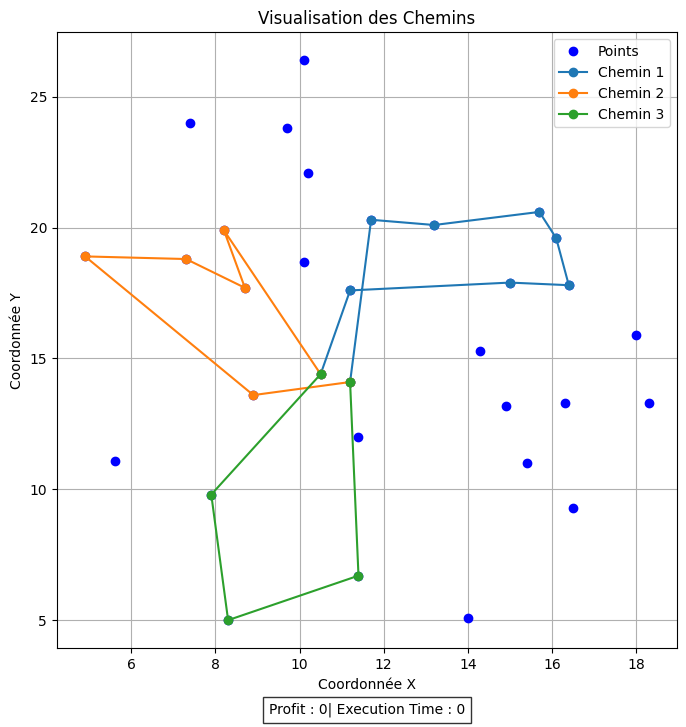

In [70]:
visualize_paths(graph_object.nodes, solution, 0, 0)


In [88]:
print(graph_object.times)

{((10.5, 14.4), (18.0, 15.9)): 7.648529270389178, ((10.5, 14.4), (18.3, 13.3)): 7.877182237323193, ((10.5, 14.4), (16.5, 9.3)): 7.874642849044013, ((10.5, 14.4), (15.4, 11.0)): 5.964059020499379, ((10.5, 14.4), (14.9, 13.2)): 4.560701700396552, ((10.5, 14.4), (16.3, 13.3)): 5.903388857258177, ((10.5, 14.4), (16.4, 17.8)): 6.809552114493286, ((10.5, 14.4), (15.0, 17.9)): 5.700877125495689, ((10.5, 14.4), (16.1, 19.6)): 7.641989269817122, ((10.5, 14.4), (15.7, 20.6)): 8.091971329657564, ((10.5, 14.4), (13.2, 20.1)): 6.307138812488592, ((10.5, 14.4), (14.3, 15.3)): 3.905124837953328, ((10.5, 14.4), (14.0, 5.1)): 9.936800289831734, ((10.5, 14.4), (11.4, 6.7)): 7.752418977325723, ((10.5, 14.4), (8.3, 5.0)): 9.654014708917737, ((10.5, 14.4), (7.9, 9.8)): 5.283937925449162, ((10.5, 14.4), (11.4, 12.0)): 2.5632011235952596, ((10.5, 14.4), (11.2, 17.6)): 3.2756678708318407, ((10.5, 14.4), (10.1, 18.7)): 4.3185645763378355, ((10.5, 14.4), (11.7, 20.3)): 6.020797289396148, ((10.5, 14.4), (10.2, 2

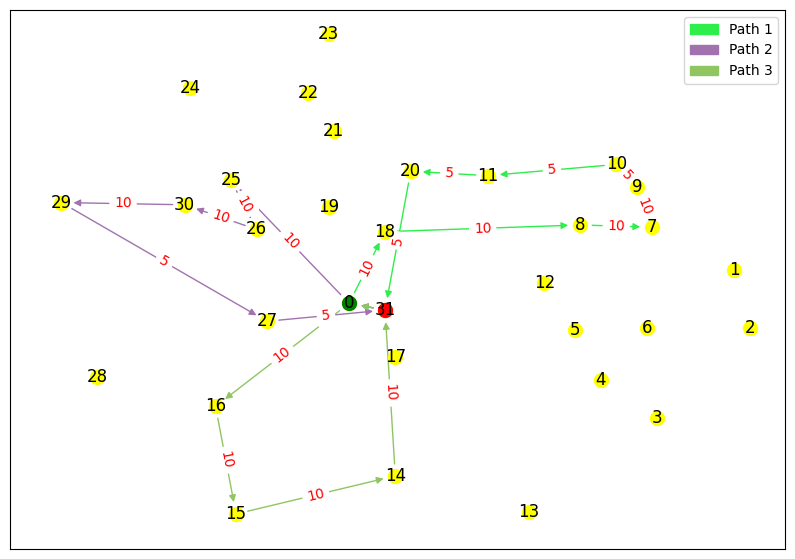

In [107]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def drawGraph(graph: Graph, solution):
    nbCustomers = len(graph.nodes)
    colors = ['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(len(solution))]
    plt.figure(figsize=(10, 7))    
    options = {
        'node_size': 100,
        'node_color': 'yellow',
    }

    G = nx.DiGraph()
    G.add_nodes_from(range(nbCustomers))
    pos = {i: (x, y) for i, (x, y) in enumerate(graph.nodes)}

    nx.draw_networkx_nodes(G, pos=pos, **options)
    nx.draw_networkx_labels(G, pos=pos)

    edge_labels = {} 

    for k, path in enumerate(solution):
        mapped_path = [graph.nodes.index(node) for node in path]
        truck_edges = [(mapped_path[i], mapped_path[i + 1]) for i in range(len(mapped_path) - 1)]
        truck_edges.append((mapped_path[-1], mapped_path[0]))
        #print(f"Path {k + 1}:", path)
        nx.draw_networkx_edges(G, pos=pos, edgelist=truck_edges, edge_color=colors[k], label=f'Path {k + 1}')

        edge_labels.update({(mapped_path[i], mapped_path[i + 1]): f'{round(graph.profits[graph.nodes[i + 1]],1)}' for i in range(len(mapped_path) - 1)})

    nx.draw_networkx_nodes(G, pos=pos, nodelist=[0], node_color='green', node_size=100)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[nbCustomers-1], node_color='red', node_size=100)

    colorbox = [mpatches.Patch(color=colors[k], label=f'Path {k + 1}') for k in range(len(solution))]
    plt.legend(handles=colorbox, loc='best')

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.show()
drawGraph(graph_object,solution)